In [0]:
import keras
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten, Dense
from keras.layers.convolutional import Conv2D, MaxPooling2D

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_directory = "drive/My Drive/Autonomous-Car-Project/data/"
image_labels = pd.read_csv(data_directory + 'signnames.csv').values
label_count = image_labels.shape[0]

with open(data_directory + "train.p", "rb") as file:
    np_train_data = pickle.load(file)

with open(data_directory + "valid.p", "rb") as file:
    np_valid_data = pickle.load(file)
    
with open(data_directory + "test.p", "rb") as file:
    np_test_data = pickle.load(file)

In [0]:
np_train_features, np_train_labels = np_train_data['features'], np_train_data['labels'] 
np_valid_features, np_valid_labels = np_valid_data['features'], np_valid_data['labels'] 
np_test_features,  np_test_labels  = np_test_data['features'],  np_test_data['labels'] 

In [0]:
np_train_features = np_train_features / 255
np_valid_features = np_valid_features / 255
np_test_features  = np_test_features  / 255

In [0]:
from keras.preprocessing.image import ImageDataGenerator
 
data_generator = ImageDataGenerator(
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.2,
                    shear_range=0.1,
                    rotation_range=10)
 
data_generator.fit(np_train_features)

In [72]:
print("-----TRAIN FEATURES-----")
print(np_train_features.shape)

print("-----VALID FEATURES-----")
print(np_valid_features.shape)

print("------TEST FEATURES-----")
print(np_test_features.shape)

-----TRAIN FEATURES-----
(34799, 32, 32, 3)
-----VALID FEATURES-----
(4410, 32, 32, 3)
------TEST FEATURES-----
(12630, 32, 32, 3)


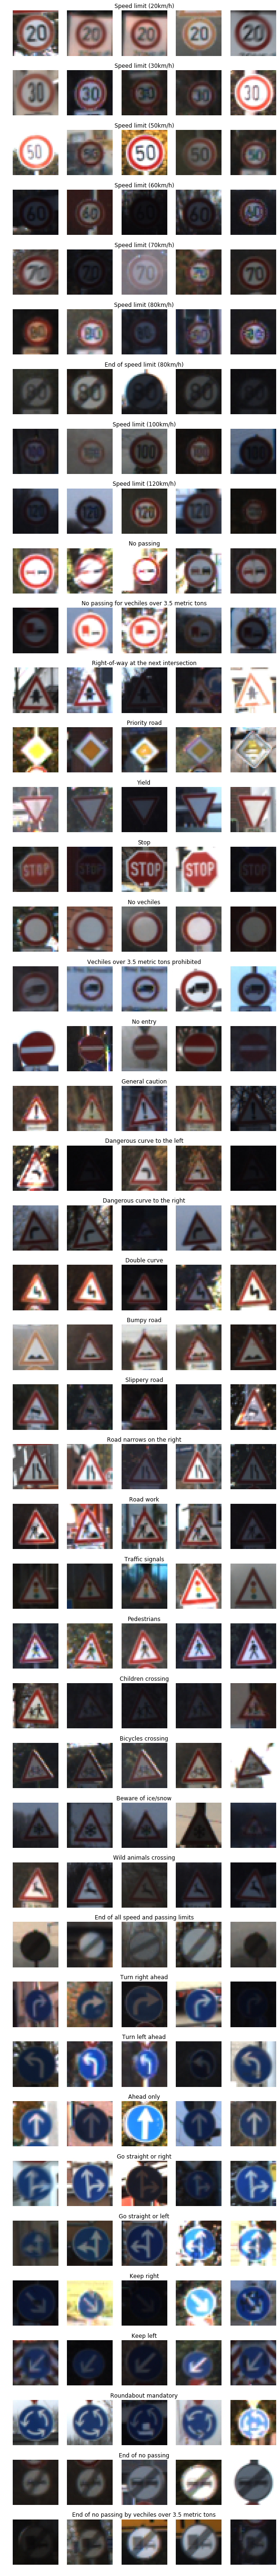

In [73]:
col_of_sample_images = 5
figure = plt.figure(figsize=(10,100))    
figure.tight_layout()
num_of_samples = []

for label_index in range(label_count):
    train_features_selected = np_train_features[np_train_labels == label_index]
    selected_count = train_features_selected.shape[0]
    num_of_samples.append(selected_count)
    
    for col_index in range(col_of_sample_images):  
        index = label_index * col_of_sample_images + col_index
        axes = figure.add_subplot(label_count, col_of_sample_images, index+1)
        rand_index = random.randint(0, selected_count)
        image = train_features_selected[rand_index]
        
        if (col_index == 2):
            plt.title(image_labels[label_index][1])
            
        plt.imshow(image) 
        plt.axis('off')

plt.show()    

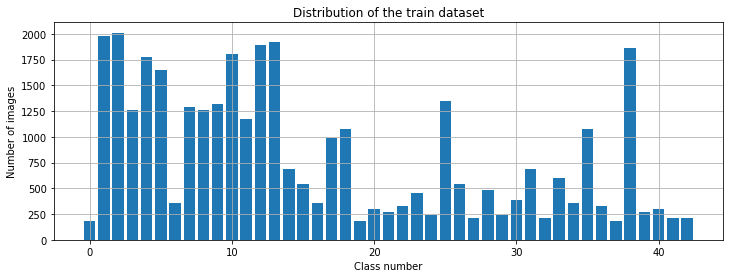

In [74]:
plt.figure(figsize=(12, 4))
plt.bar(range(0, label_count), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.grid()

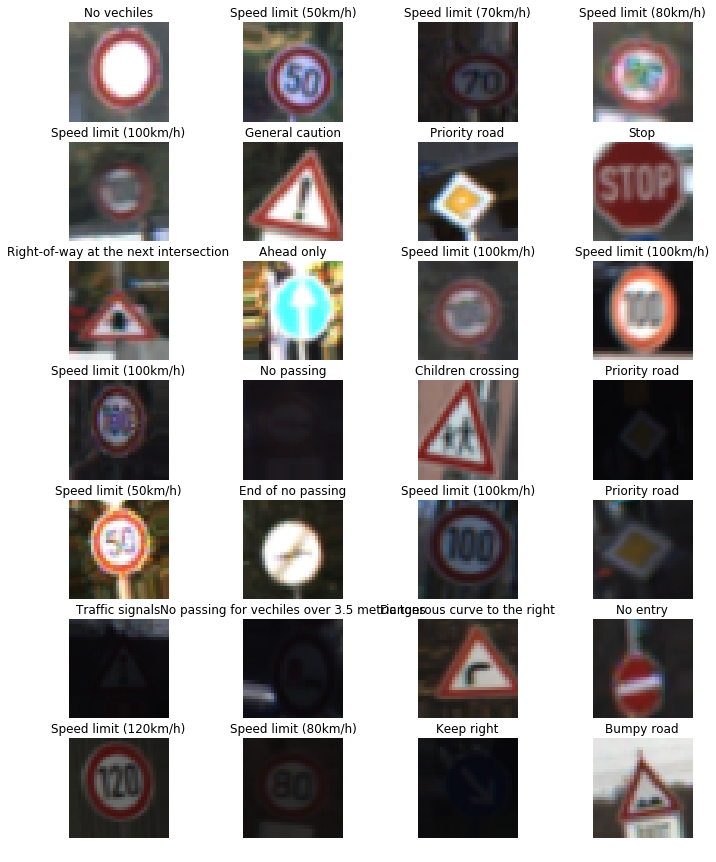

In [77]:
sample_batch_size = 28
sample_batches = data_generator.flow(np_train_features, np_train_labels, batch_size=sample_batch_size)
np_sample_feature, np_sample_label = next(sample_batches)

figure = plt.figure(figsize=(12,15))    
figure.tight_layout()

for index in range(sample_batch_size):
    axes = figure.add_subplot(7, 4, index+1)
    title = image_labels[np_sample_label[index]][1]
    plt.imshow(np_sample_feature[index]) 
    plt.title(title)
    plt.axis('off')

plt.show()

In [0]:
np_train_labels_cat = to_categorical(np_train_labels, 43)
np_valid_labels_cat = to_categorical(np_valid_labels, 43)
np_test_labels_cat  = to_categorical(np_test_labels,  43)

In [0]:
def create_lenet_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 3), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(30, (3,3), activation='relu'))    
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))
    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [80]:
model = create_lenet_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 28, 28, 60)        4560      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 480)               0         
__________

In [81]:
history=model.fit_generator(data_generator.flow(np_train_features, np_train_labels_cat, batch_size = 50), 
                            validation_data=(np_valid_features, np_valid_labels_cat), 
                            epochs=10, steps_per_epoch=2000, shuffle = 1)

Epoch 1/10
2000/2000 [==============================] - 86s 43ms/step - loss: 0.9642 - acc: 0.7128 - val_loss: 0.1630 - val_acc: 0.9542
Epoch 2/10
2000/2000 [==============================] - 86s 43ms/step - loss: 0.1916 - acc: 0.9409 - val_loss: 0.0898 - val_acc: 0.9730
Epoch 3/10
2000/2000 [==============================] - 85s 43ms/step - loss: 0.1219 - acc: 0.9629 - val_loss: 0.1096 - val_acc: 0.9741
Epoch 4/10
2000/2000 [==============================] - 86s 43ms/step - loss: 0.0961 - acc: 0.9715 - val_loss: 0.0771 - val_acc: 0.9805
Epoch 5/10
2000/2000 [==============================] - 86s 43ms/step - loss: 0.0788 - acc: 0.9763 - val_loss: 0.0695 - val_acc: 0.9816
Epoch 6/10
2000/2000 [==============================] - 85s 43ms/step - loss: 0.0707 - acc: 0.9787 - val_loss: 0.0673 - val_acc: 0.9848
Epoch 7/10
2000/2000 [==============================] - 85s 43ms/step - loss: 0.0636 - acc: 0.9811 - val_loss: 0.0763 - val_acc: 0.9807
Epoch 8/10
2000/2000 [==========================

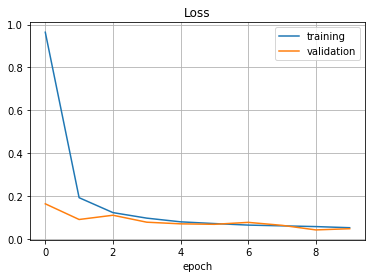

In [82]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.grid()

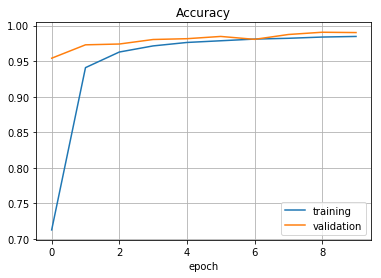

In [83]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.grid()

In [84]:
score = model.evaluate(np_test_features, np_test_labels_cat, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.10826609203913004
Test accuracy: 0.9774346793821098


In [0]:
sample_test_size = 28
np_test_predictions = model.predict_classes(np_test_features)

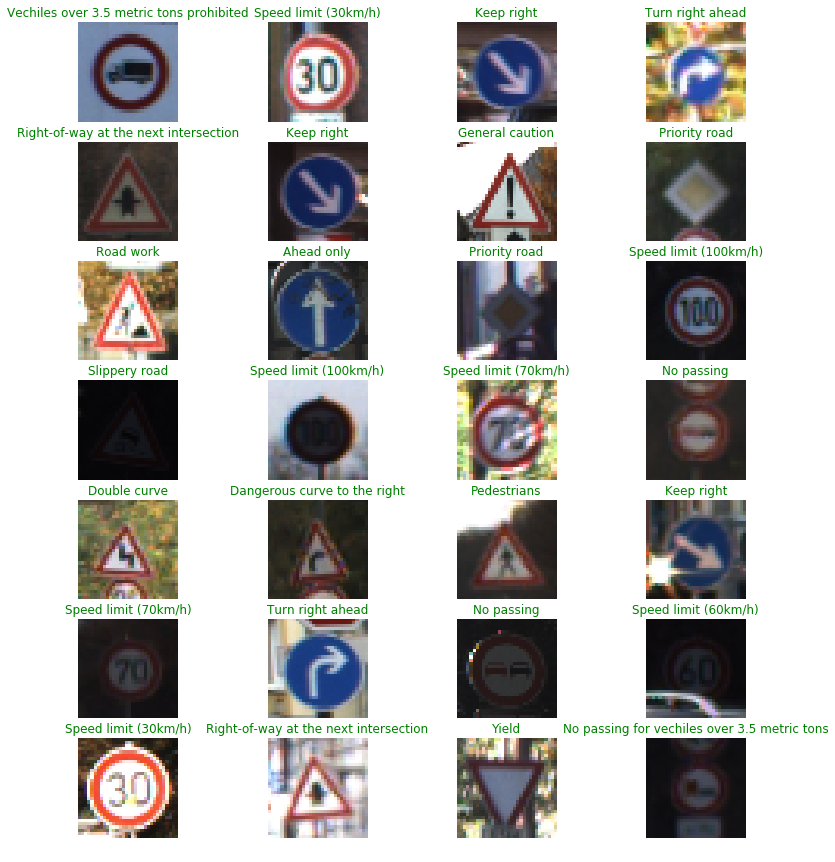

In [86]:
figure = plt.figure(figsize=(13,15))    
figure.tight_layout()

for index in range(sample_test_size):
    axes = figure.add_subplot(7, 4, index+1)
    label_prediction = image_labels[np_test_predictions[index]][1]
    label_actual = image_labels[np_test_labels[index]][1]
    plt.imshow(np_test_features[index]) 
    plt.axis('off')

    if(label_prediction == label_actual):
        plt.title(label_prediction, color="green")
    else:
        plt.title(label_prediction, color="red")
    
plt.show()

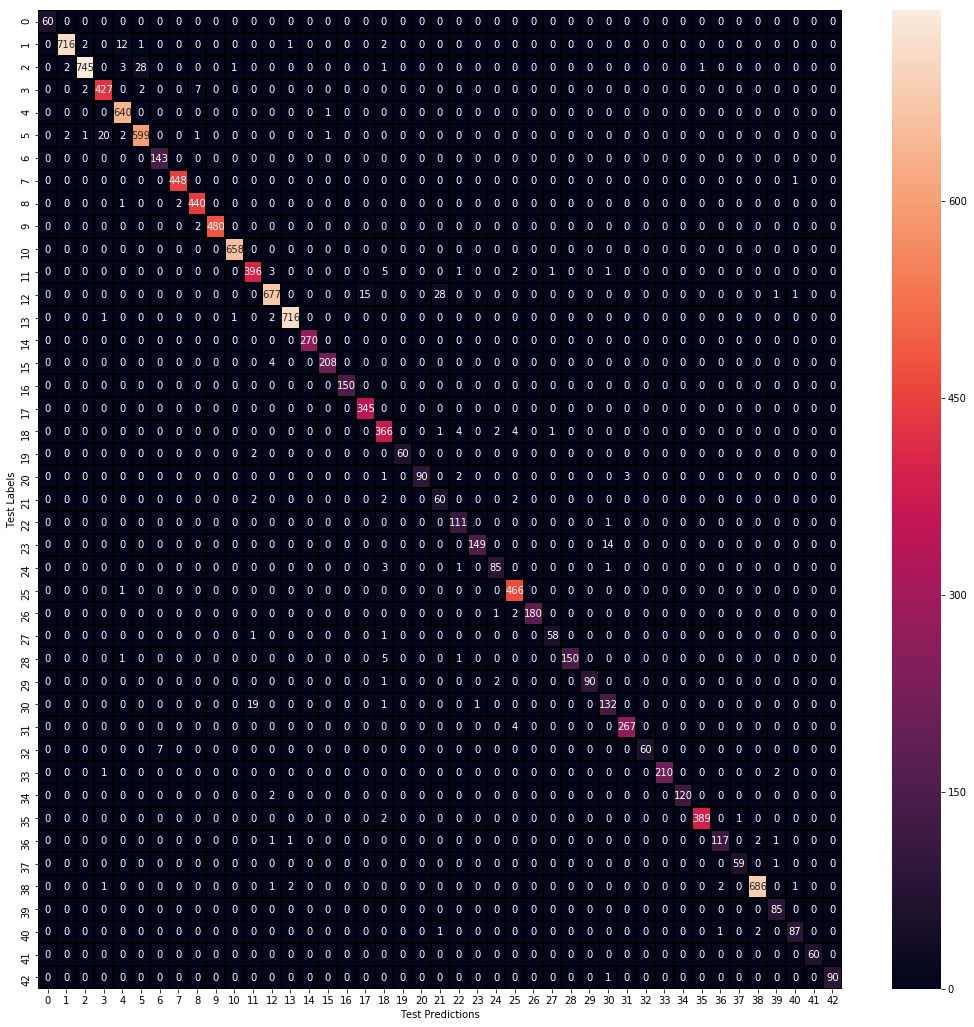

In [87]:
# plotting confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(np_test_predictions, np_test_labels)

f, ax = plt.subplots(figsize = (18, 18))
sns.heatmap(cm, annot = True, linewidths=1, linecolor='black', fmt='.0f', ax=ax)
plt.xlabel("Test Predictions")
plt.ylabel("Test Labels")
plt.show()